# COUNTLAND: python tutorial
### Samuel H. Church

The following packages are required to complete the tutorial

In [2]:
import sys
import logging

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
plt.style.use('classic')
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import seaborn as sns

import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map="viridis")

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.2 scipy==1.6.3 pandas==1.3.3 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


## GET THE DATA

We have used the PBMC3k benchmark dataset.  
`countland` accepts an AnnData object, same as `scanpy` 

In [3]:
#!mkdir data
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
#!mkdir write

adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                             # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


## IMPORT COUNTLAND
The code is located in `countland.py`

In [4]:
import countland as clnd

In [80]:
import importlib
importlib.reload(clnd)

<module 'counterspace' from '/gpfs/ysm/home/sc2962/220122_countland/counterspace.py'>

## INITIALIZE COUNTLAND OBJECT

In [81]:
C = clnd.countland(adata)
print(C)

Initializing counterspace object

        counterspace object
        Count matrix has 2700 cells (rows) 
         and 32738 genes (columns)
        The fraction of entries that are nonzero is 0.0259
        


The count matrix is stored in `C.counts`

In [82]:
C.counts

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Note that most counts are zero for scRNA-seq data.

## FILTER GENES AND CELLS

In [83]:
C.SubsetGenes(np.sum(C.counts,axis=0) > 0) # only genes with counts detected


New number of genes: 16634


In [84]:
C.SubsetCells(np.sum(C.counts,axis=1) > 0) # only cells with counts detected


New number of cells: 2700


You can return to the original count matrix at any time using
`C.RestoreCounts()`

## SUBSAMPLE GENES

Cells are not sequenced to standard sequencing depth. This is sometimes a problem for downstream comparisons.  

You can subsample all cells to a standard number of counts using `C.Subsample()`. The number of counts must not be larger than the minimum number per cell.

In [85]:
np.random.seed(84095) # choose a random seed for reproducibility
C.Subsample(n_counts = 500)

In [86]:
np.count_nonzero(C.subsample,axis=0)

array([ 3,  0,  0, ...,  0, 22, 11])

## COMPARE GENES BY COUNTS

Using the subsampled count matrix, we can compare expression using several count-based assessments. These include:

- maximum number of counts observed across cells
- total counts per gene
- number of cells with counts above 0, 1, or 10
- number of unique count values
- count index = number of _n_ cells with _n_ counts

In [87]:
C.ScoreGenes()
C.gene_scores.sort_values(by="unique_count_values",ascending=False)

,names,max_count_value,total_counts,counts_above0,counts_above1,counts_above10,unique_count_values,count_index
9562,MALAT1,89,37871,2687,2637,1649,65,26
15720,FTL,68,14830,2115,1490,569,45,22
9449,FTH1,45,11039,2129,1441,374,40,19
6775,TMSB4X,59,26307,2697,2665,1010,39,20
11892,B2M,46,26293,2691,2655,991,38,21
...,...,...,...,...,...,...,...,...
10568,RP11-320P7.1,0,0,0,0,0,0,0
13782,RP5-1107A17.3,0,0,0,0,0,0,0
6814,YY2,0,0,0,0,0,0,0
6816,PTCHD1,0,0,0,0,0,0,0


In [88]:
####  NEED TO UPDATE THE PLOT HERE 

unique_names = C.gene_scores.sort_values(by="total_counts",ascending=False).names.unique()
colors_dict = dict(zip(unique_names,np.append(sns.color_palette("tab10",10).as_hex(),np.repeat("black",len(C.gene_scores.names)-10)))) # colors to markers


## SELECT CERTAIN GENES (AKA PROJECTING ONTO SUBSPACE)

A common practice in single-cell analysis is to only use certain features (genes) for clustering. These can be selected by estimated parameter values, such as high variance. 

Using count-based methods, there may not be a need to filter genes. However, for speed of analysis here, we have focused on the top 500 genes ranked by the number of unique count values per gene.

In [89]:
gene_names = C.gene_scores.sort_values(by="unique_count_values",ascending=False).head(500)['names']
gene_indices = np.where(np.isin(C.names_genes,gene_names))[0]
C.SubsetGenes(gene_indices)
C.SubsetCells(np.where(np.max(C.counts,axis=1)>0)[0]) # only cells with at least one count

New number of genes: 500
New number of cells: 2700


## CLUSTER BY DOT PRODUCTS

The dot (or inner) product is a measure of alignment between vectors. In this case, it tells us how similar to cells are based on the proportions of counts, and scaled by the total counts per cell. A dot product of 0 indicates orthogonal cell vectors (no shared counts), larger values indicate aligned cell vectors.

In [90]:
C.Dot()

Calculating dot products between rows...
    done.


Cell populations can be distinguished by clustering the matrix of pairwise dot products (contained in `C.dots`). This matrix is an unbounded affinity matrix. It is symmetric, and contains only integer values above 0. Spectral clustering is appropriate for this type of matrix.

The number of clusters depends on the system in question...

In [91]:
## NEED A BETTER SYSTEM FOR DECIDING N CLUSTERS

C.Cluster(n_clusters=7)

performing spectral clustering on dot products...
    done.


## SPECTRAL EMBEDDING OF DOT PRODUCTS

We can use the dot product matrix to visualize cell similarity. This takes advantage of spectral embedding to plot cells in a space with reduced dimensionality.

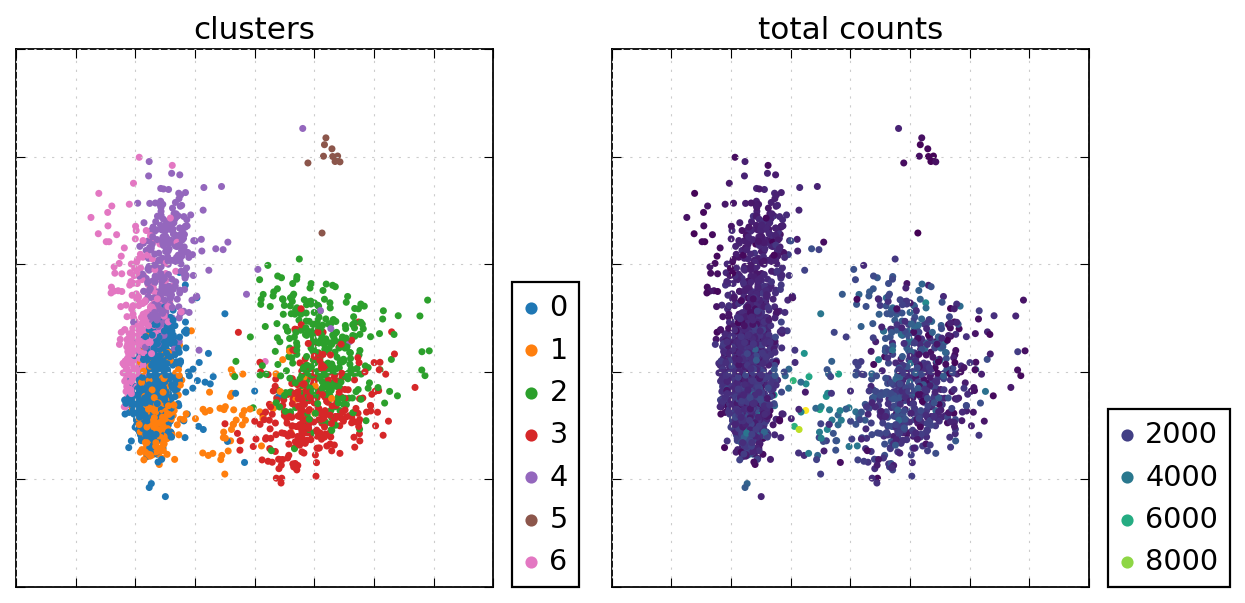

In [92]:
C.PlotClusters()

## IDENTIFY MARKER GENES

What makes a gene an ideal marker for a cluster may depend on downstream applications. For example, the ideal marker gene might be defined as the gene detected in all of the  cells in a given cluster and none of the rest.

Under this definition, the top marker gene for each cluster can be identified by counting and comparing the number of non-zero cells.

In [93]:
C.RankMarkerGenes(method='prop-zero')
gdf = C.marker_genes.loc[(C.marker_genes['cluster_label'] == 5)]
gdf

,diff. proportion zero,rank,gene index,gene names,cluster_label
176,0.989219,1,176,GNG11,5
70,0.987732,2,70,SDPR,5
102,0.987732,2,102,PF4,5
287,0.974721,4,287,CD9,5
103,0.974349,5,103,PPBP,5
136,0.967658,6,136,HIST1H2AC,5
207,0.884387,7,207,CLU,5
423,0.883643,8,423,TUBB1,5
447,0.873606,9,447,TPM4,5
211,0.784015,10,211,CA2,5


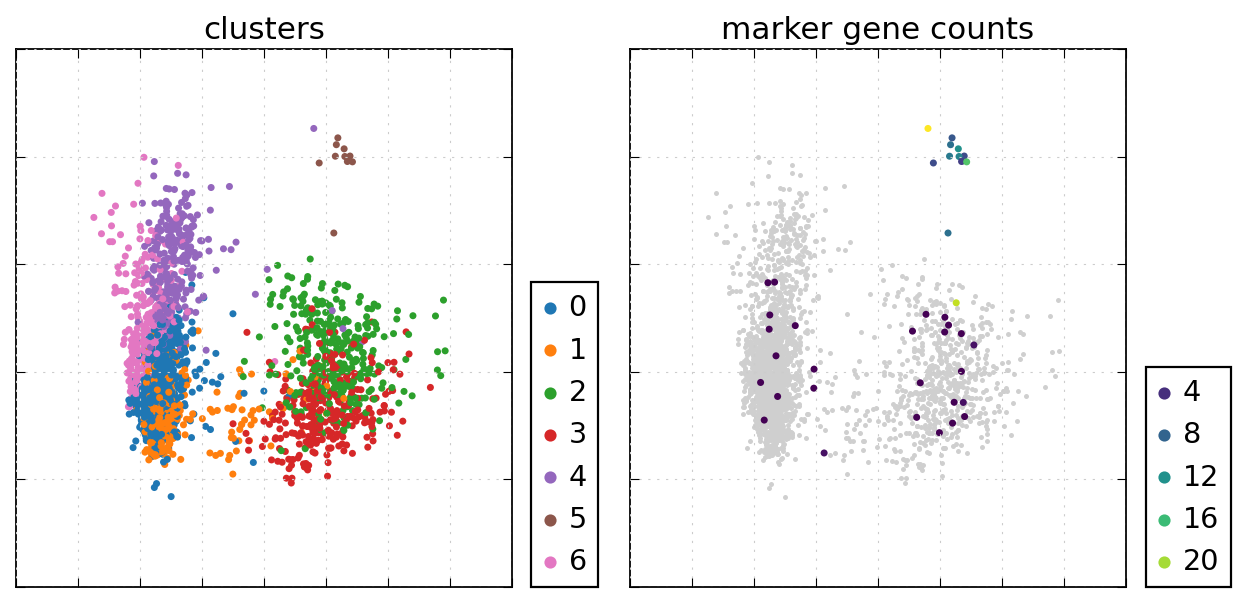

In [94]:
gene_index = gdf.loc[(gdf['cluster_label'] == 5) & (gdf['rank'] == 1)]['gene index'].values
C.PlotMarker(gene_index)

Alternatively, the top marker genes for each cluster can be identified by ranking genes using the Wilcoxon rank-sum statistic.

In [95]:
C.RankMarkerGenes(method='rank-sums')
gdf = C.marker_genes.loc[(C.marker_genes['cluster_label'] == 5)]
gdf

,test-statistic,p-value,adjusted-p-value,significant diff.,rank,gene index,gene names,cluster_label
103,11.5,1.0,1.0,False,1,103,PPBP,5
287,16.5,1.0,1.0,False,2,287,CD9,5
176,20.0,1.0,1.0,False,3,176,GNG11,5
70,21.0,1.0,1.0,False,4,70,SDPR,5
102,30.0,1.0,1.0,False,5,102,PF4,5
136,84.5,1.0,1.0,False,6,136,HIST1H2AC,5
447,343.0,1.0,1.0,False,7,447,TPM4,5
85,363.0,1.0,1.0,False,8,85,GPX1,5
41,909.0,1.0,1.0,False,9,41,TAGLN2,5
207,1370.5,1.0,1.0,False,10,207,CLU,5


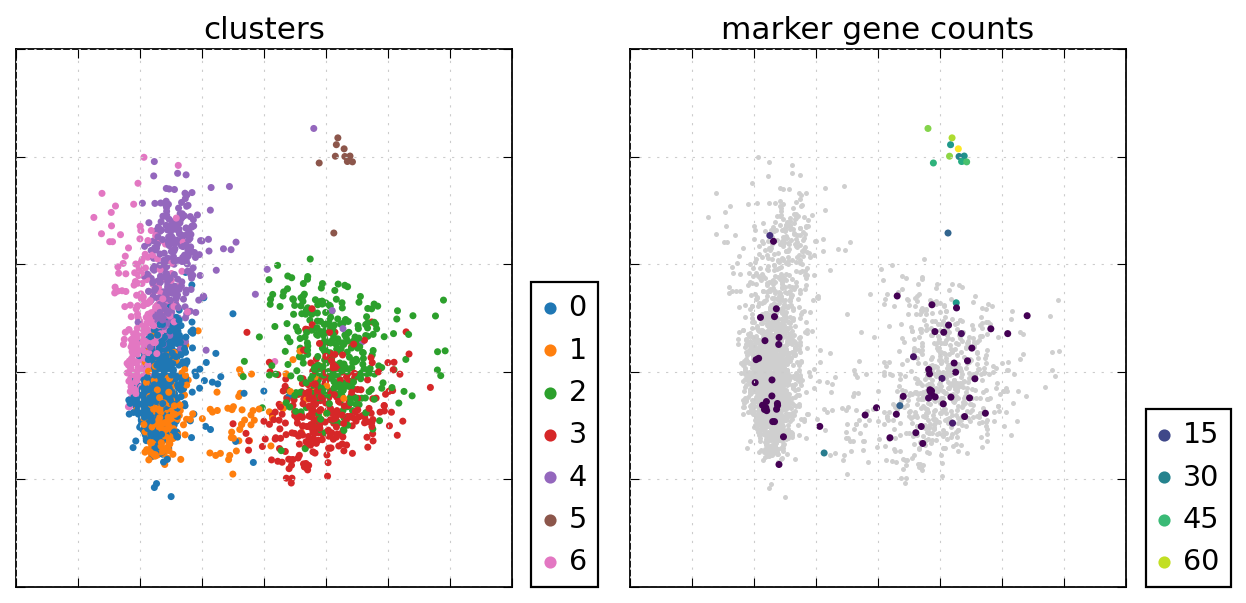

In [96]:
gene_index = gdf.loc[(gdf['cluster_label'] == 5) & (gdf['rank'] == 1)]['gene index'].values 
C.PlotMarker(gene_index)

## DIMENSIONAL REDUCTION AND LOW RANK APPROXIMATION

In addition to spectral embedding of dot products, there are several other approaches for visualizing cells in reduced dimensions.

### GLM-PCA

An alternative approach for comparing cells using untransformed counts is generalized linear model based PCA, or GLM-PCA. This has been described for scRNA-seq data [here](https://doi.org/10.1186/s13059-019-1861-6) and implemented [here](https://github.com/willtownes/glmpca-py).

In [ ]:
#!pip install git+https://github.com/willtownes/glmpca-py.git@master
from glmpca import glmpca

res = glmpca.glmpca(C.counts.T,2,fam="poi") # embed in 2 dimensions and use a Poisson model

In [ ]:
plt.figure(figsize = (6,6))

g = sns.scatterplot(x = res['factors'][:,0], # embeddings are stored in res['factors']
                y = res['factors'][:,1],
                hue = C.cluster_labels,
                palette="tab10",
                s =10,
                linewidth=0)
g.legend(loc=(1.04,0))
g.xaxis.set_ticklabels([])
g.yaxis.set_ticklabels([])
g.set(title="GLM-PCA: dot product clusters")

In [ ]:
plt.figure(figsize = (6,6))

g = sns.scatterplot(x = res['factors'][:,0], 
            y = res['factors'][:,1], 
            color = "#CFCFCF",
            s = 5,
            linewidth=0)
sci = np.where(C.counts[:,gene_index]>0)[0]
sns.scatterplot(ax = g,
            x = res['factors'][sci,0], 
            y = res['factors'][sci,1], 
            hue = C.counts[sci,gene_index],
            palette = "viridis",
            s = 10,
            linewidth=0) 
g.legend(loc=(1.04,0))
g.xaxis.set_ticklabels([])
g.yaxis.set_ticklabels([])
g.set(title="GLM-PCA: dot product clusters")

### INTEGER MATRIX APPROXIMATION

This method, described [here](https://mtchu.math.ncsu.edu/Research/Papers/bindec05f.pdf), seeks to identify a set of matrices that can be multiplied together to approximate a matrix of integers, here the count matrix. In this way it is similar to other rank reduction methods, like singular value decomposition.

IMA produces three matrices, $\mathrm{U}$, $\mathrm{V}$, and $\Lambda$. The matrix $\mathrm{U}$ has the dimensions cells x features, where the number of features is the target reduction determined by the user. The matrix $\mathrm{V}$ has the dimensions genes x features, and $\Lambda$ is a diagonal scaling matrix. The bounds of the integer values in each matrix can be changed to accomodate the data in question.

We can identify a good target rank by visualizing how many dimensions are required to best approximate the count matrix. 

**Note that this takes some time (~4 mins)**

In [ ]:
C.PlotIMAElbow(max_features = 20, u_bounds = [5,10]) # compare results up to 20 features, 
                            # with upper bounds of 5 for matrix U and 10 for matrix V. 

Based on the elbow plot above, the approximation does not appear to improve by adding features beyond ~15.

In [ ]:
C.IMA(features = 15, u_bounds = [5,10])

We can visualize cells by embedding counts (matrix $\mathrm{C}$) in this reduced space. This is calculated with matrix multiplication $\mathrm{C(V}\Lambda)$.

In [ ]:
C.PlotIMA(x = 0, y = 1) # visualize cells using the features 0 and 1
            # Note that features are not necessarily ordered

### COLLAPSING GROUPS OF GENES 

Another method for reducing the dimensions is to collapse groups of genes with similar patterns of counts across cells. Here we can accomplish this by calculating the number of shared counts between all pairs of genes, identifying clusters of genes with similar counts, and then summing counts within clusters.

Because calculating pairwise shared count values is memory intensive, this is performed using a random sample of cells, set with `n_cells`, default `100`. 

In [ ]:
C.SharedCounts(n_clusters=7)

In [ ]:
C.PlotSharedCounts(x = 0, y = 1)

## RECAPITULATING STANDARD APPROACHES

`countland` also includes functions for recapitulating the standard transformation steps for scRNA-seq data.
**Note that these are not recommended**

In [ ]:
C._Normalize()
C._Log()
C._RescaleVariance()
C._Center()